<a href="https://colab.research.google.com/github/veroorli/ProjetProg/blob/master/Tme6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Master DAC, BDLE, 2021 
* Author: Mohamed-Amine Baazizi
* Affiliation: LIP6 - Faculté des Sciences - Sorbonne Université
* Email: mohamed-amine.baazizi@lip6.fr




```
# This is formatted as code
```

## Préparation

Vérifier que des ressources de calcul sont allouées à votre notebook est connecté (cf RAM  de disque indiqués en haut à droite) . Sinon cliquer sur le bouton connecter pour obtenir des ressources.




Pour accéder directement aux fichiers stockées sur votre google drive. Renseigner le code d'authentification lorsqu'il est demandé

Ajuster le nom de votre dossier : MyDrive/ens/bdle/dir. **Remplacer dir **

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

drive_dir = "/content/drive/MyDrive/bdle/dir"
os.makedirs(drive_dir, exist_ok=True)
os.listdir(drive_dir)

Mounted at /content/drive


[]

Installer pyspark et findspark :


In [ ]:
!pip install -q pyspark
!pip install -q findspark

Démarrer la session spark

In [ ]:
import os
# !find /usr/local -name "pyspark"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.7/dist-packages/pyspark"
os.environ["JAVA_HOME"] = "/usr"

In [ ]:
# Principaux import
import findspark
from pyspark.sql import SparkSession 
from pyspark import SparkConf  

# pour les dataframe et udf
from pyspark.sql import *  
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

# pour le chronomètre
import time

# initialise les variables d'environnement pour spark
findspark.init()

# Démarrage session spark 
# --------------------------
def demarrer_spark():
  local = "local[*]"
  appName = "TP"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory")
  
  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (4 coeurs)
  spark.conf.set("spark.sql.shuffle.partitions","4")    
  print("session démarrée, son id est ", sc.applicationId)
  return spark
spark = demarrer_spark()

session démarrée, son id est  local-1637518604335


In [ ]:
# on utilise 8 partitions au lieu de 200 par défaut
spark.conf.set("spark.sql.shuffle.partitions", "8")
print("Nombre de partitions utilisées : ",
      spark.conf.get("spark.sql.shuffle.partitions"))

Nombre de partitions utilisées :  8


## Import des fonctions ML:

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

## Data loading et préparation du Dataset


Il s'agit ici de données trouvées sur Kaggle qui sont issues de l'API de spotify. Nous avons ici des informations concernant **232725** chansons, et un label de popularité (int allant de 0 à 100, 100 étant le plus populaire). Nous essaieront ici de trouver la popularité de la chanson en partant des autres features pertinents.

### Définition du schema

In [ ]:
path = "./drive/MyDrive/ens/bdle/projet2/" 
customSchema = StructType([StructField('genre', StringType(), nullable=True),
                           StructField('artist_name', StringType(), True),
                           StructField('track_name', StringType(), nullable=False),
                           StructField('track_id', StringType(), nullable=False),
                           StructField('popularity', IntegerType(), nullable=False),
                           StructField('acousticness', FloatType(), True),
                           StructField('danceability', FloatType(), True),
                           StructField('duration_ms', FloatType(), True),
                           StructField('energy', FloatType(), True),
                           StructField('instrumentalness', FloatType(), True),
                           StructField('key', StringType(), True),
                           StructField('liveness', FloatType(), True),
                           StructField('loudness', FloatType(), True),
                           StructField('mode', StringType(), True),
                           StructField('speechiness', FloatType(), True),
                           StructField('tempo', FloatType(), True),
                           StructField('time_signature', StringType(), True),
                           StructField('valence', FloatType(), True)
                           ])
ori_df = spark.read.format("csv").option("header", "true").schema(customSchema).load(path +"SpotifyFeatures.csv")
str_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(path +"SpotifyFeatures.csv")

In [ ]:
df = ori_df
df.show()

+-----+--------------------+--------------------+--------------------+----------+------------+------------+-----------+------+----------------+---+--------+--------+-----+-----------+-------+--------------+-------+
|genre|         artist_name|          track_name|            track_id|popularity|acousticness|danceability|duration_ms|energy|instrumentalness|key|liveness|loudness| mode|speechiness|  tempo|time_signature|valence|
+-----+--------------------+--------------------+--------------------+----------+------------+------------+-----------+------+----------------+---+--------+--------+-----+-----------+-------+--------------+-------+
|Movie|      Henri Salvador|C'est beau de fai...|0BRjO6ga9RKCKjfDq...|         0|       0.611|       0.389|    99373.0|  0.91|             0.0| C#|   0.346|  -1.828|Major|     0.0525|166.969|           4/4|  0.814|
|Movie|   Martin & les fées|Perdu d'avance (p...|0BjC1NfoEOOusryeh...|         1|       0.246|        0.59|   137373.0| 0.737|             0

In [ ]:
df.printSchema()
row_count = df.count()
column_count = len(df.columns)
print('nb de lignes:', row_count)
print('nb de colonnes:', column_count)

root
 |-- genre: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- danceability: float (nullable = true)
 |-- duration_ms: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- key: string (nullable = true)
 |-- liveness: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- time_signature: string (nullable = true)
 |-- valence: float (nullable = true)

nb de lignes: 232725
nb de colonnes: 18


### Filtre des rows avec décalage:

On a remarqué que certaines lignes du dataset ont des lignes dont le label n'est pas un int mais des strings (M, H, L), et n'ayant pas trouvé à quoi correspondent ces lignes on a décidé de les enlever car elles ne correspondent à moins de 1% des données. (Les valeurs correspondent probablement à Low, Medium et High mais on n'as pas de valeur ints concrétes à assigner à chaque row)

In [ ]:
(1-df.filter(df.popularity.cast("int").isNotNull()).count()/row_count)

0.004391449135245473

In [ ]:
df = df.filter(df.popularity.cast("int").isNotNull())
.filter(~df.popularity.contains("."))

In [ ]:
df.select("popularity").distinct().count()

101

### Check des Valeurs nulles:

Ici on calcule le pourcentage des valeurs nulles.

In [ ]:
print("Pourcentage des valeurs nulles")
for column in df.columns:
  print(column, ": ", "{:.5%}"
  .format(df.filter(col(column).isNull()).count()/row_count))


Pourcentage des valeurs nulles
genre :  0.00000%
artist_name :  0.00000%
track_name :  0.00000%
track_id :  0.00000%
popularity :  0.00000%
acousticness :  0.00000%
danceability :  0.00043%
duration_ms :  0.00000%
energy :  0.00000%
instrumentalness :  0.00000%
key :  0.00000%
liveness :  0.00043%
loudness :  0.00000%
mode :  0.00000%
speechiness :  0.00043%
tempo :  0.00000%
time_signature :  0.00000%
valence :  0.00043%


In [ ]:
str_df.filter("track_id  = '0bvEKvSwtUFIz00'").show()

+-------+-----------+----------+---------------+----------+------------+------------+-----------+------+----------------+------+--------+--------+-----+-----------+-----+--------------+-------+
|  genre|artist_name|track_name|       track_id|popularity|acousticness|danceability|duration_ms|energy|instrumentalness|   key|liveness|loudness| mode|speechiness|tempo|time_signature|valence|
+-------+-----------+----------+---------------+----------+------------+------------+-----------+------+----------------+------+--------+--------+-----+-----------+-----+--------------+-------+
|Country|  Jake Owen|Ghost Town|0bvEKvSwtUFIz00|      0.82|           0|           C|     0.0839|-5.825|           Major|0.0674| 112.938|     4/4|0.697|       null| null|          null|   null|
+-------+-----------+----------+---------------+----------+------------+------------+-----------+------+----------------+------+--------+--------+-----+-----------+-----+--------------+-------+



#### Drop des valeurs nulles

In [ ]:
df = df.na.drop("any")

In [ ]:
print("Pourcentage des valeurs nulles")
for column in df.columns:
  print(column, ": ", "{:.5%}"
  .format(df.filter(col(column).isNull()).count()/row_count))


Pourcentage des valeurs nulles
genre :  0.00000%
artist_name :  0.00000%
track_name :  0.00000%
track_id :  0.00000%
popularity :  0.00000%
acousticness :  0.00000%
danceability :  0.00000%
duration_ms :  0.00000%
energy :  0.00000%
instrumentalness :  0.00000%
key :  0.00000%
liveness :  0.00000%
loudness :  0.00000%
mode :  0.00000%
speechiness :  0.00000%
tempo :  0.00000%
time_signature :  0.00000%
valence :  0.00000%


## Pourcentages des valeurs distinctes pour chaque feature

In [ ]:
print("Pourcentage des valeures dist")
for column in df.columns:
  print(column, ": ", "{:.5%}"
  .format(df.select(column).distinct().count()/row_count))

Pourcentage des valeures dist
genre :  0.01160%
artist_name :  6.25502%
track_name :  63.43109%
track_id :  75.52777%
popularity :  0.04340%
acousticness :  2.03416%
danceability :  0.55645%
duration_ms :  30.31346%
energy :  1.07939%
instrumentalness :  2.32034%
key :  0.00516%
liveness :  0.74423%
loudness :  11.94672%
mode :  0.00086%
speechiness :  0.70512%
tempo :  33.59373%
time_signature :  0.00215%
valence :  0.72704%


Vu que les colonnes: artist_name, track_name, et track_id ont trop de valeurs distinctes on décide de les enlever plus tard.

### "Binning" values

Ici on effectue un binning (ou bucketizing) des colonnes en nous basant sur des informations issus de la théorie musicale

In [ ]:
df_columns = df.columns

#### **Tempo**

On divise les chansons en 3 catégories selon le tempo: lentes (moins de 108bpm), moyennes (entre 108 et 120bpm) et rapides (plus de 120bpm).
Source: https://en.wikipedia.org/wiki/Tempo

In [ ]:
def ceil_tempo(row, low=108, high=120):
  t = float(row.tempo)
  new_row = row.asDict()
  if t<=high:
    if t<low:
      new_row["tempo"] = "low"
    else:
      new_row["tempo"] = 'medium'
  else:
    new_row["tempo"] = 'high'
  return Row(**new_row)

#### **Duration**

On divise les chansons en 3 catégories selon leur durées tempo: courtes (moins de 2mins), moyennes (entre 2 et 5mins) et longues (plus de 5mins).

In [ ]:
def ceil_duration(row, short=120000, long=300000):
  new_row = row.asDict()
  t = int(new_row["duration_ms"])
  if t<=long:
    if t<short:
      new_row["duration_ms"] = "short"
    else:
      new_row["duration_ms"] = 'medium'
  else:
    new_row["duration_ms"] = 'long'
  return Row(**new_row)

In [ ]:
rdd = df.rdd.map(lambda r: ceil_duration(ceil_tempo(r)))

In [ ]:
df = rdd.toDF()

In [ ]:
df.show()

+-----+--------------------+--------------------+--------------------+----------+--------------------+-------------------+-----------+-------------------+--------------------+---+-------------------+-------------------+-----+--------------------+------+--------------+-------------------+
|genre|         artist_name|          track_name|            track_id|popularity|        acousticness|       danceability|duration_ms|             energy|    instrumentalness|key|           liveness|           loudness| mode|         speechiness| tempo|time_signature|            valence|
+-----+--------------------+--------------------+--------------------+----------+--------------------+-------------------+-----------+-------------------+--------------------+---+-------------------+-------------------+-----+--------------------+------+--------------+-------------------+
|Movie|      Henri Salvador|C'est beau de fai...|0BRjO6ga9RKCKjfDq...|         0|  0.6110000014305115| 0.3889999985694885|      short

In [ ]:
df.filter("tempo = 'high'").count()/row_count

0.45136534536470085

In [ ]:
df.filter("tempo = 'medium'").count()/row_count

0.1228144806101622

In [ ]:
df.filter("tempo = 'low'").count()/row_count

0.4214201310559673

###Sélection de features  pertinents


In [ ]:
df = df.drop("track_name", "track_id", "artist_name")
df.show()

+-----+----------+--------------------+-------------------+-----------+-------------------+--------------------+---+-------------------+-------------------+-----+--------------------+------+--------------+-------------------+
|genre|popularity|        acousticness|       danceability|duration_ms|             energy|    instrumentalness|key|           liveness|           loudness| mode|         speechiness| tempo|time_signature|            valence|
+-----+----------+--------------------+-------------------+-----------+-------------------+--------------------+---+-------------------+-------------------+-----+--------------------+------+--------------+-------------------+
|Movie|         0|  0.6110000014305115| 0.3889999985694885|      short| 0.9100000262260437|                 0.0| C#|0.34599998593330383|-1.8279999494552612|Major| 0.05249999836087227|  high|           4/4| 0.8140000104904175|
|Movie|         1|  0.2460000067949295| 0.5899999737739563|     medium| 0.7369999885559082|     

## Decision Tree


Ici on prépare les données pour les indexer (pipeline ci dessous).

In [ ]:
label = 'popularity'
str_features_col = 
["genre", "key", "mode", "tempo", "time_signature", "duration_ms"]
prefix = 'indexed_'
features_str_col = list(map(lambda c:prefix+c, str_features_col))
features_string_indexer =
 StringIndexer(inputCols=str_features_col, outputCols=features_str_col)
features_col = df.columns
features_col.remove(label)

In [ ]:
dec_features_col =
 [feature for feature in features_col if feature not in str_features_col]

In [ ]:
vec_assembler = VectorAssembler(inputCols = dec_features_col 
                + features_string_indexer.getOutputCols(), outputCol= 'vector')
vec_indexer = 
VectorIndexer(inputCol='vector', outputCol='features', maxCategories=20)
dt = DecisionTreeRegressor(featuresCol="features", labelCol=label)

In [ ]:
stages = [features_string_indexer, vec_assembler, vec_indexer, dt]

#### Split des données en train et test

In [ ]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = df.randomSplit([0.7, 0.3])

#### Cross validation et gridsearch des meilleurs paramètres:
On recherche ici la meilleure profondeur et bins de l'arbre de décision.

In [ ]:
pipeline = Pipeline(stages = stages)

dtparamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(dt.maxBins, [30, 40, 50])
             .build())

rmseevaluator = 
RegressionEvaluator(labelCol=label, predictionCol="prediction", metricName="rmse")
maeevaluator = 
RegressionEvaluator(labelCol=label, predictionCol="prediction", metricName="mae")

dtcv = CrossValidator(estimator = pipeline,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = rmseevaluator,
                      numFolds = 3)

model = dtcv.fit(trainingData)

#### Plot des scores

In [ ]:
scores = model.avgMetrics
maxDepths = []
maxBins = []
for modelParam in dtparamGrid:
  for key in modelParam:
    if key.name=='maxDepth':
      maxDepths.append(modelParam[key])
    else:
      maxBins.append(modelParam[key])
print(maxDepths)


[2, 2, 2, 5, 5, 5, 10, 10, 10, 20, 20, 20, 30, 30, 30]


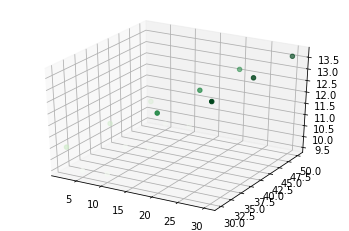

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(maxDepths, maxBins, scores, c=scores, cmap='Greens');

In [ ]:
# Make predictions.
predictions = model.transform(testData)
predictions.prediction = 
predictions.select(round("prediction").alias("prediction"))
# Select example rows to display.
predictions.select("prediction", label, "features").show(5)

# Select (prediction, true label) and compute test error

rmse = rmseevaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

mae = maeevaluator.evaluate(predictions)


print("Mean Absolute Error (MAE) on test data = %g" % mae)

+------------------+----------+--------------------+
|        prediction|popularity|            features|
+------------------+----------+--------------------+
|13.626892147587512|         0|[0.56900000572204...|
|13.626892147587512|         0|[0.80000001192092...|
|13.626892147587512|         0|[0.90100002288818...|
|13.626892147587512|         0|[0.95499998331069...|
|13.626892147587512|         1|[0.58200001716613...|
+------------------+----------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 9.57436
Mean Absolute Error (MAE) on test data = 7.25118


### Features catégoriques originales seulement:
Ici on supprime toutes les informations qui sont issus de l'API spotify et on ne garde que les infos basiques des chansons, et on utilise donc que des features catégoriques originales de la chanson i.e: **genre, duration, key, tempo, mode, time signature**

Ici on prépare les données pour les indexer (pipeline ci dessous).

In [ ]:
label = 'popularity'
str_features_col = ["genre", "key", "mode", "tempo", "time_signature",
                    "duration_ms"]
prefix = 'indexed_'
features_str_col = list(map(lambda c:prefix+c, str_features_col))
features_string_indexer = StringIndexer(inputCols=str_features_col, 
                                        outputCols=features_str_col)
features_col = df.columns
features_col.remove(label)

In [ ]:
dec_features_col = [feature for feature in features_col 
                    if feature not in str_features_col]

In [ ]:
vec_assembler = VectorAssembler(inputCols = features_string_indexer
                                .getOutputCols(), outputCol= 'vector')
vec_indexer = VectorIndexer(inputCol='vector', outputCol='features',
                            maxCategories=20)
dt = DecisionTreeRegressor(featuresCol="features", labelCol=label)

In [ ]:
stages = [features_string_indexer, vec_assembler, vec_indexer, dt]

#### Split des données en train et test

In [ ]:
df_cat = df.drop("acousticness", "danceability", "energy", "instrumentalness",
                 "liveness", "loudness", "speechiness", "valence")

In [ ]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = df_cat.randomSplit([0.7, 0.3])

#### Cross validation et gridsearch des meilleurs paramètres:
On recherche ici la meilleure profondeur et bins de l'arbre de décision.

In [ ]:
pipeline = Pipeline(stages = stages)

dtparamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(dt.maxBins, [30, 40, 50])
             .build())

rmseevaluator = RegressionEvaluator(labelCol=label,
                                    predictionCol="prediction", metricName="rmse")
maeevaluator = RegressionEvaluator(labelCol=label, 
                                   predictionCol="prediction", metricName="mae")

dtcv = CrossValidator(estimator = pipeline,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = rmseevaluator,
                      numFolds = 3)

model = dtcv.fit(trainingData)

#### Plot des scores

In [ ]:
scores = model.avgMetrics
maxDepths = []
maxBins = []
for modelParam in dtparamGrid:
  for key in modelParam:
    if key.name=='maxDepth':
      maxDepths.append(modelParam[key])
    else:
      maxBins.append(modelParam[key])
print(maxDepths)


[2, 2, 2, 5, 5, 5, 10, 10, 10, 20, 20, 20, 30, 30, 30]


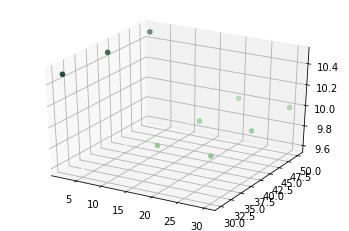

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(maxDepths, maxBins, scores, c=scores, cmap='Greens');

In [ ]:
# Make predictions.
predictions = model.transform(testData)
predictions.prediction = predictions.select(round("prediction")
.alias("prediction"))
# Select example rows to display.
predictions.select("prediction", label, "features").show(5)

# Select (prediction, true label) and compute test error

rmse = rmseevaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

mae = maeevaluator.evaluate(predictions)


print("Mean Absolute Error (MAE) on test data = %g" % mae)

+-----------------+----------+--------------------+
|       prediction|popularity|            features|
+-----------------+----------+--------------------+
|12.06522911051213|         0|(6,[0,3],[26.0,1.0])|
|12.06522911051213|         0|[26.0,7.0,0.0,0.0...|
|12.06522911051213|         0|[26.0,10.0,0.0,1....|
|12.06522911051213|         1|      (6,[0],[26.0])|
|12.06522911051213|         1|[26.0,3.0,1.0,0.0...|
+-----------------+----------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 9.63461
Mean Absolute Error (MAE) on test data = 7.27601


##END